In [64]:
from typing import List

# utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series

# forecast
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

# models
import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# evolution
from utilsforecast.losses import rmse, mae, mape, smape
from utilsforecast.evaluation import evaluate
from mlforecast.utils import PredictionIntervals

pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize = (10, 8))
plt.rc("font", size = 10)

# params

In [68]:
freq = "h"
horizon = 24
n_windows = 7

# data

In [65]:
def load_data():
    # data path
    data_url = "https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJM_Load_hourly.csv"
    # data read
    df = pd.read_csv(data_url, parse_dates = ["Datetime"])
    # data rename
    df.columns = ["ds", "y"]
    # add unique_id col
    df.insert(0, "unique_id", "PJM_Load_hourly")
    # ds transform
    df["ds"] = pd.to_datetime(df["ds"])
    # sort
    df = df.sort_values(["unique_id", "ds"]).reset_index(drop = True)
    
    return df

In [66]:
df = load_data()
print(df.head())
print()
print(df.tail())
print()
print(df.shape)

         unique_id                  ds        y
0  PJM_Load_hourly 1998-04-01 01:00:00  22259.0
1  PJM_Load_hourly 1998-04-01 02:00:00  21244.0
2  PJM_Load_hourly 1998-04-01 03:00:00  20651.0
3  PJM_Load_hourly 1998-04-01 04:00:00  20421.0
4  PJM_Load_hourly 1998-04-01 05:00:00  20713.0

             unique_id                  ds        y
32891  PJM_Load_hourly 2001-12-31 20:00:00  36392.0
32892  PJM_Load_hourly 2001-12-31 21:00:00  35082.0
32893  PJM_Load_hourly 2001-12-31 22:00:00  33890.0
32894  PJM_Load_hourly 2001-12-31 23:00:00  32590.0
32895  PJM_Load_hourly 2002-01-01 00:00:00  31569.0

(32896, 3)


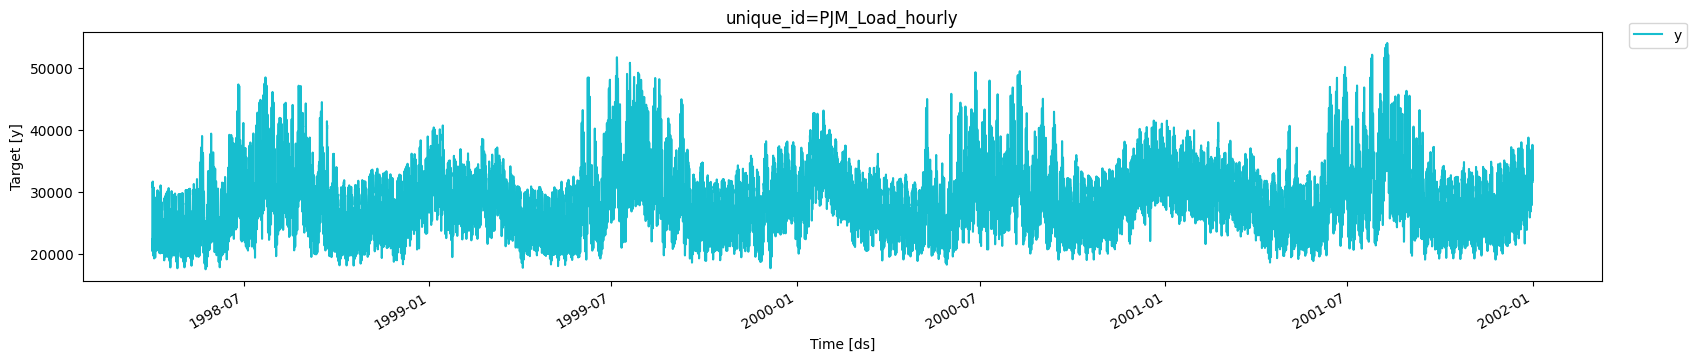

In [67]:
fig = plot_series(df)
fig

# data split

In [69]:
threshold_time = df["ds"].max() - pd.Timedelta(hours = horizon)

# train dataset
df_train = df.loc[df["ds"] <= threshold_time, :]
# test dataset
df_last_24_hours = df.loc[df["ds"] > threshold_time, :]
print(df_train.shape)
print(df_last_24_hours.shape)

(32872, 3)
(24, 3)


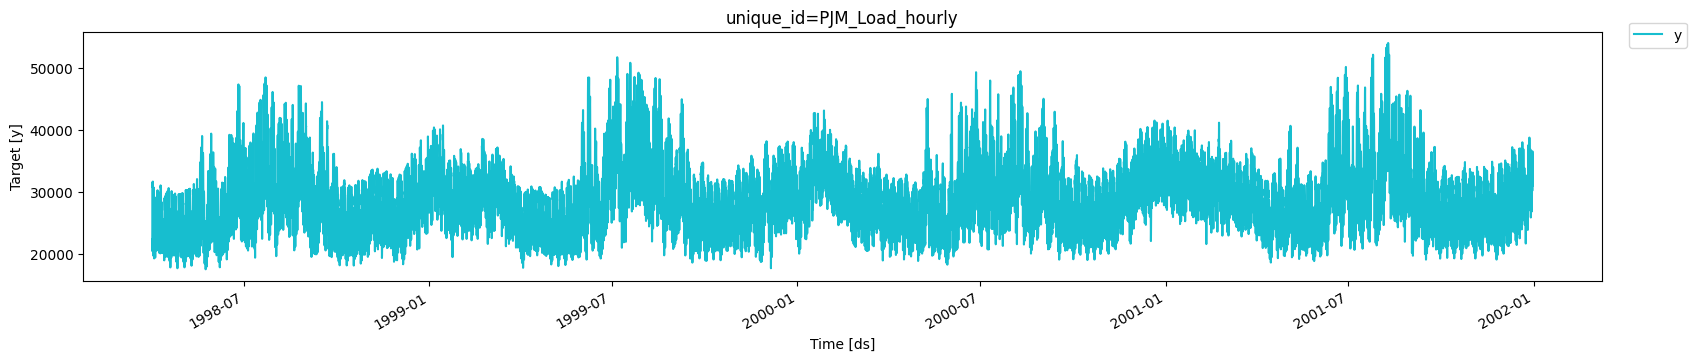

In [70]:
fig = plot_series(df_train)
fig

# 分析季节性

In [72]:
def plot_differences(df, differences: List[int]):
    prep = [df]
    
    # Plot individual Differences
    for d in differences:
        fcst = MLForecast(
            models = [],
            freq = freq,
            target_transforms = [Differences([d])],
        )
        df_ = fcst.preprocess(df)
        df_['unique_id'] = df_['unique_id'] + f'_{d}'
        prep.append(df_)
    
    # Plot combined Differences
    fcst = MLForecast(
        models = [],
        freq = freq,
        target_transforms = [Differences(differences)],
    )
    df_ = fcst.preprocess(df)
    df_['unique_id'] = df_['unique_id'] + f'_all_diff'
    prep.append(df_)

    # data concat
    prep = pd.concat(prep, ignore_index=True)
    
    # return prep
    n_series = len(prep['unique_id'].unique())
    fig, ax = plt.subplots(nrows = n_series, figsize = (7 * n_series, 10 * n_series), squeeze = False)
    for title, axi in zip(prep['unique_id'].unique(), ax.flat):
        df_ = prep[prep['unique_id'] == title]
        df_.set_index('ds')['y'].plot(title = title, ax = axi)
    # fig.savefig(f'../../figs/{fname}', bbox_inches='tight')
    plt.show()
    plt.close()

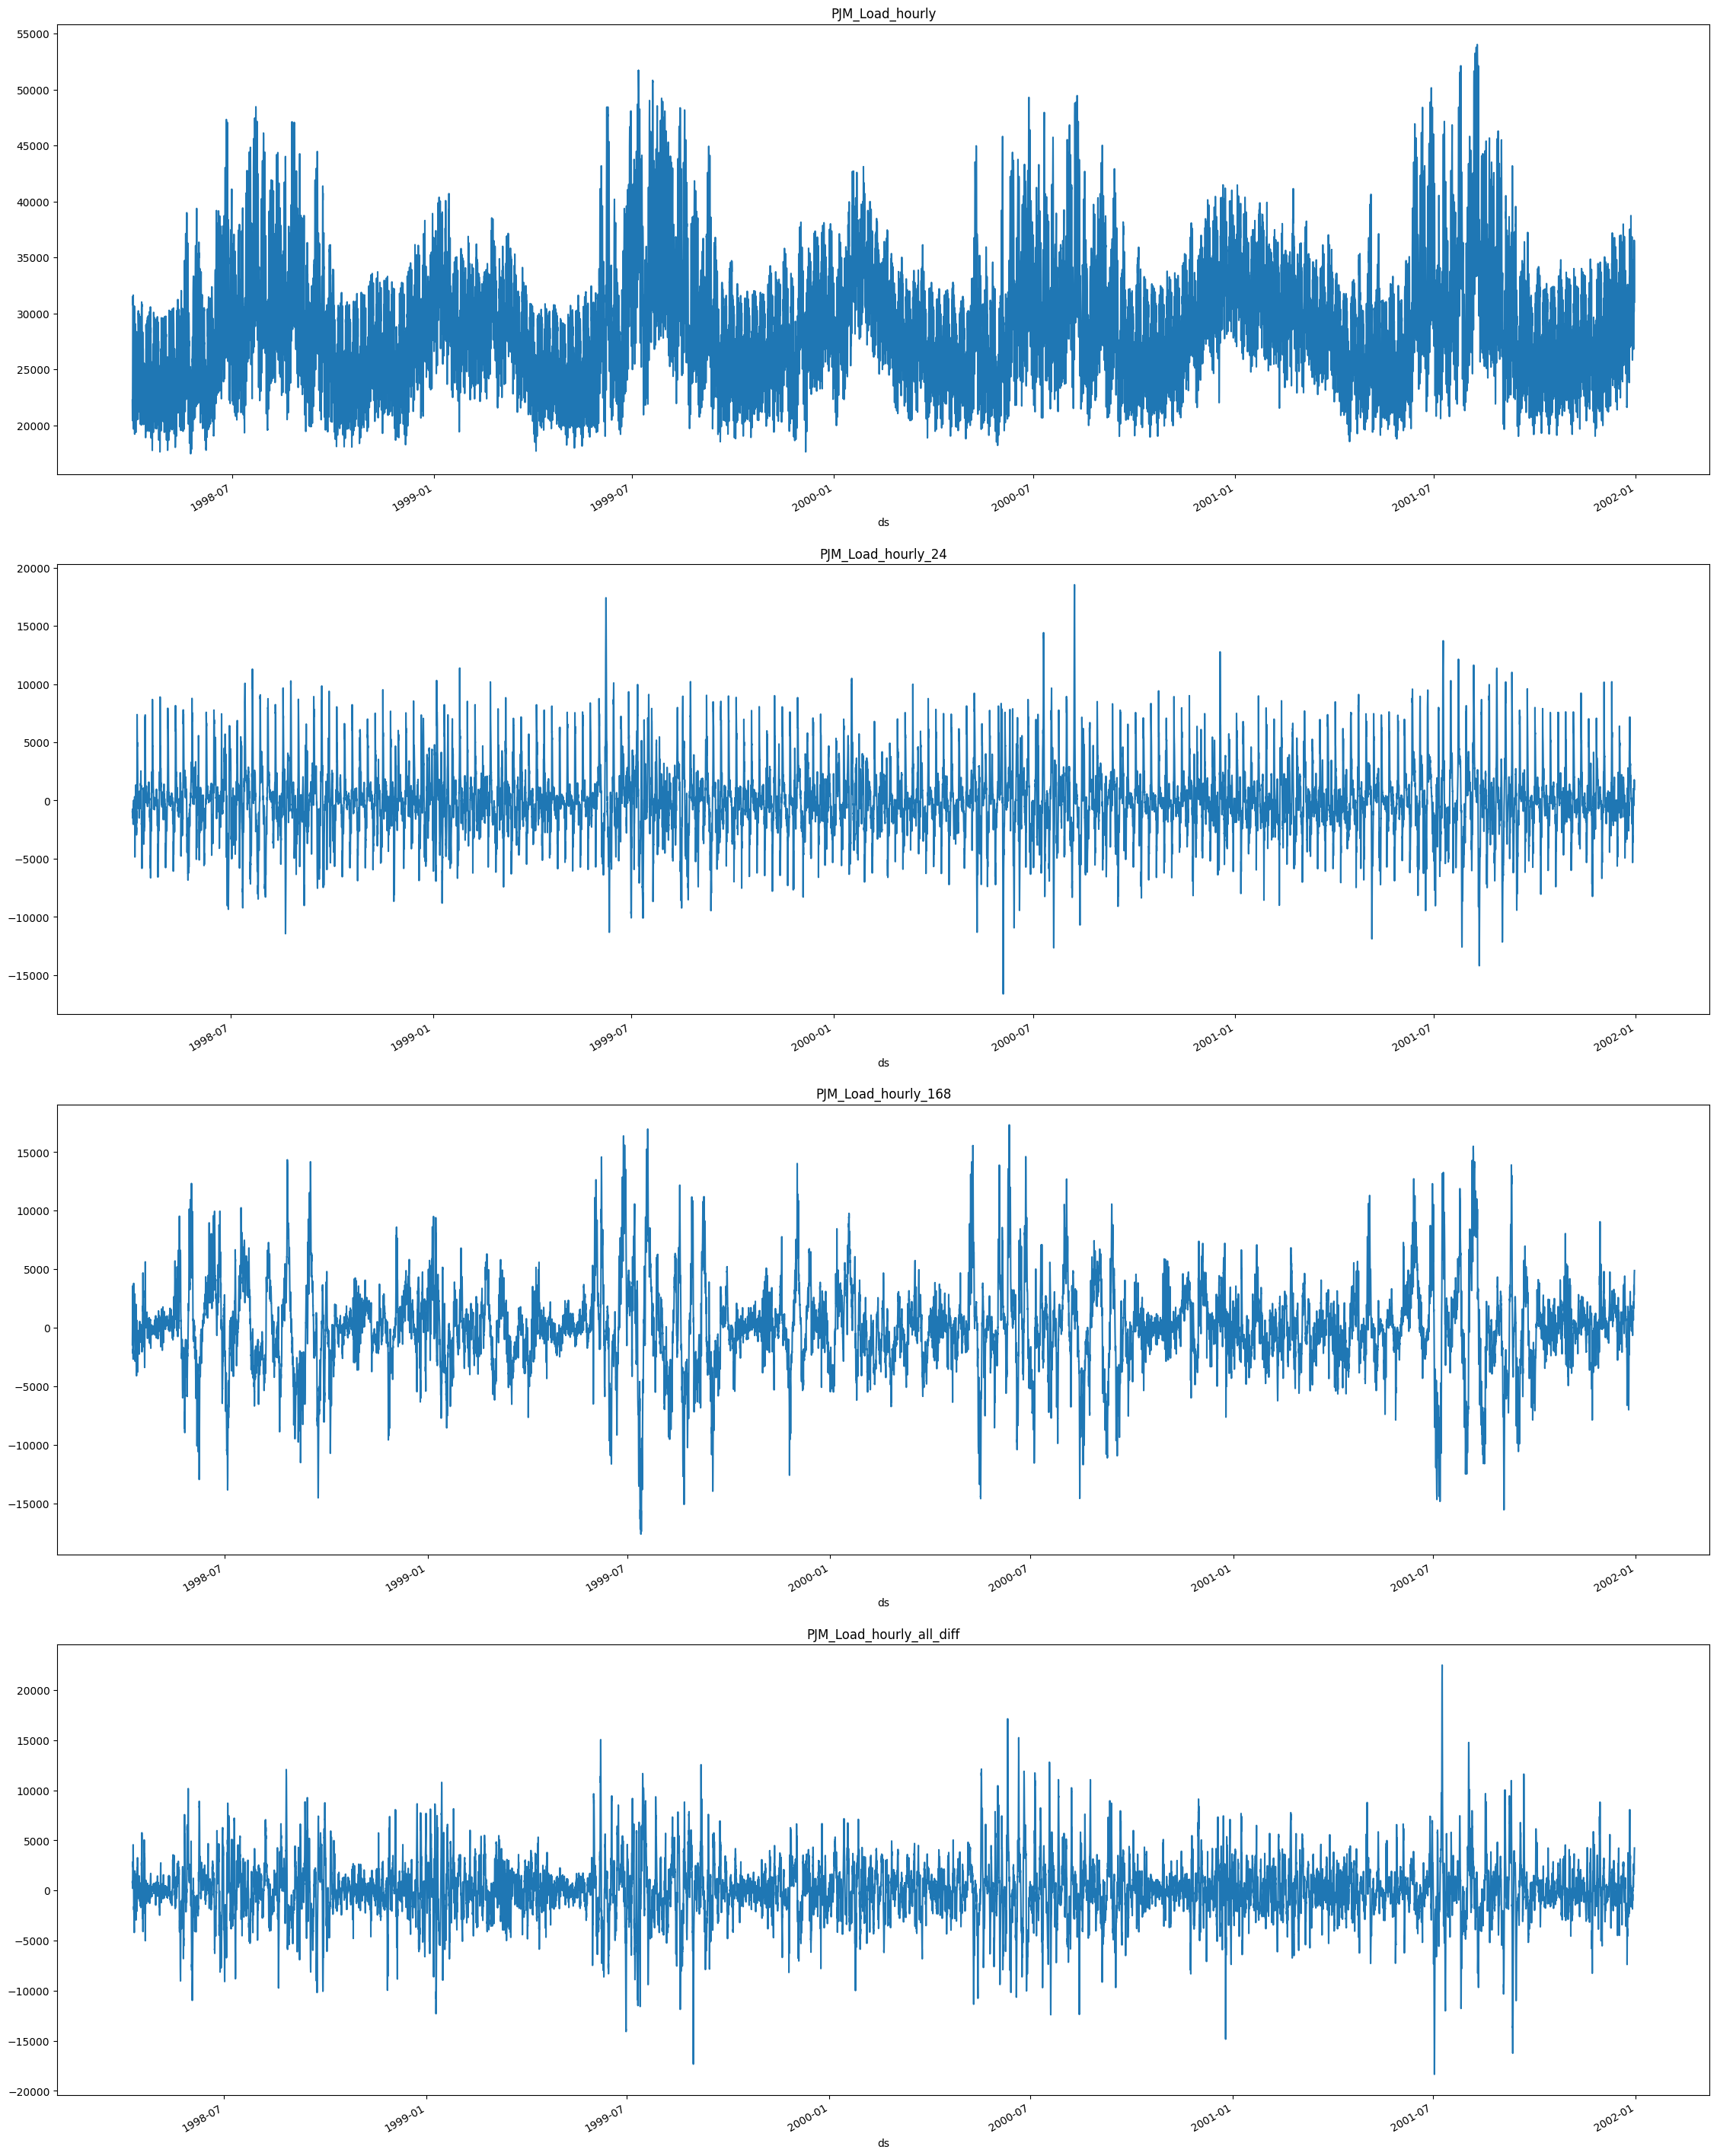

In [73]:
plot_differences(df=df_train, differences=[24, 24*7])

# 通过交叉验证进行模型选择

## 模型

In [76]:
# Model dictionary
class Naive(BaseEstimator):
    """
    navie model
    """
    
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

models ={
    'naive': Naive(),
    'lgbm': lgb.LGBMRegressor(verbosity = -1),
    'lasso': Lasso(),
    'lin_reg': LinearRegression(),
    'ridge': Ridge(),
    'knn': KNeighborsRegressor(),
    'mlp': MLPRegressor(), 
    'rf': RandomForestRegressor(),
}

In [77]:
mlf = MLForecast(
    models = models, 
    freq = freq,
    target_transforms = [Differences([24, 24*7])],
    lags=[1, 12, 24],
    lag_transforms={  
        1: [ExpandingMean()],
        24: [RollingMean(window_size = 48)],
    },
    date_features = ['month', 'hour', 'dayofweek'],
)

## 模型交叉验证

In [78]:
crossvalidation_df = mlf.cross_validation(
    df = df_train,
    h = horizon,
    n_windows = n_windows,
    refit = False,
)
print(crossvalidation_df.head())
print(crossvalidation_df.shape)

         unique_id                  ds     cutoff        y    naive  \
0  PJM_Load_hourly 2001-12-24 01:00:00 2001-12-24  23811.0  23631.0   
1  PJM_Load_hourly 2001-12-24 02:00:00 2001-12-24  22421.0  22144.0   
2  PJM_Load_hourly 2001-12-24 03:00:00 2001-12-24  21629.0  21759.0   
3  PJM_Load_hourly 2001-12-24 04:00:00 2001-12-24  21678.0  21871.0   
4  PJM_Load_hourly 2001-12-24 05:00:00 2001-12-24  21634.0  22174.0   

           lgbm         lasso       lin_reg         ridge      knn  \
0  23767.452314  23752.163356  23752.106952  23752.106955  23810.8   
1  22417.331475  22393.875486  22393.781598  22393.781604  22450.0   
2  22200.118081  22144.561756  22144.448682  22144.448692  21757.8   
3  22386.048720  22388.453794  22388.340346  22388.340359  21922.2   
4  22727.049661  22832.615457  22832.518601  22832.518617  22281.4   

            mlp        rf  
0  23719.964885  23668.78  
1  22308.294441  22228.58  
2  21999.624688  21755.79  
3  22200.984140  21897.71  
4  22597.072

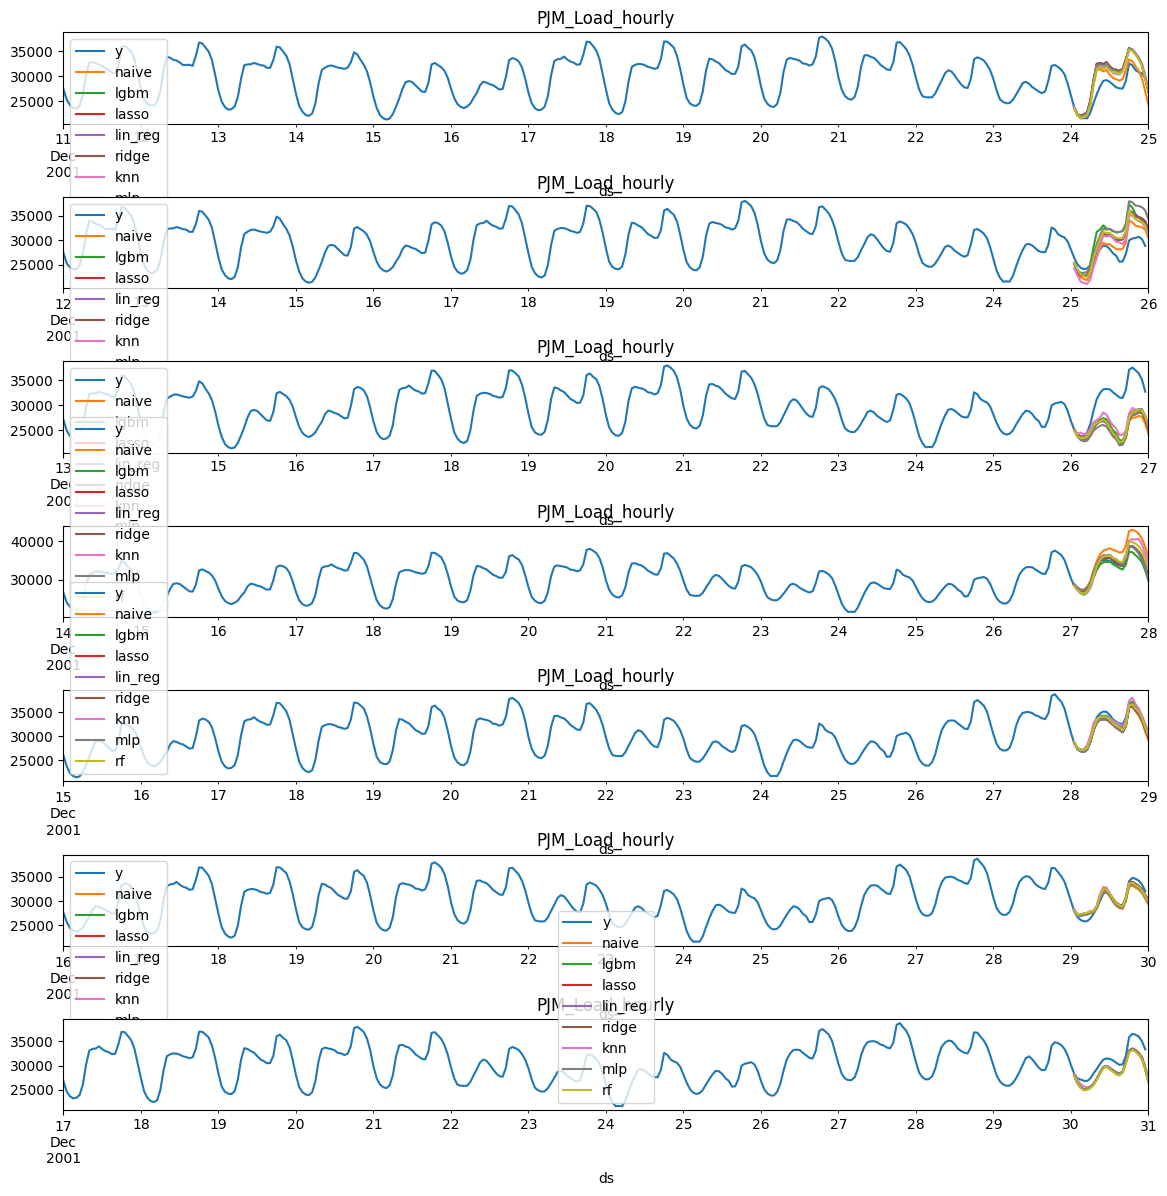

In [79]:
def plot_cv(df, df_cv, uid, fname, last_n = 24 * 14, models = {}):
    cutoffs = df_cv.query('unique_id == @uid')['cutoff'].unique()
    fig, ax = plt.subplots(nrows = len(cutoffs), ncols = 1, figsize = (14, 14), gridspec_kw = dict(hspace=0.8))
    for cutoff, axi in zip(cutoffs, ax.flat):
        max_date = df_cv.query('unique_id == @uid & cutoff == @cutoff')['ds'].max()
        df[df['ds'] < max_date].query('unique_id == @uid').tail(last_n).set_index('ds').plot(ax = axi, title = uid, y = 'y')
        for m in models.keys():
            df_cv.query('unique_id == @uid & cutoff == @cutoff').set_index('ds').plot(ax = axi, title = uid, y = m)          
    # fig.savefig(f'../../figs/{fname}', bbox_inches='tight')
    plt.show()
    plt.close()

plot_cv(
    df_train, 
    crossvalidation_df, 
    uid='PJM_Load_hourly', 
    fname='load_forecasting__predictions.png', 
    models=models
)

In [80]:
def evaluate_crossvalidation(crossvalidation_df, models):
    """
    Function to evaluate the crossvalidation
    """
    evaluations = []
    for c in crossvalidation_df['cutoff'].unique():
        df_cv = crossvalidation_df.query('cutoff == @c')
        evaluation = evaluate(
            df = df_cv,
            metrics = [mae, rmse, mape, smape],
            models=list(models.keys())
        )
        evaluations.append(evaluation)
    evaluations = pd.concat(evaluations, ignore_index=True).drop(columns='unique_id')
    evaluations = evaluations.groupby('metric').mean()
    
    return evaluations.style.background_gradient(cmap='RdYlGn_r', axis=1)

evaluate_crossvalidation(crossvalidation_df, models)

,naive,lgbm,lasso,lin_reg,ridge,knn,mlp,rf
metric,,,,,,,,
mae,2259.428571,2280.764652,2180.184100,2183.350918,2183.350886,2129.528571,2400.173658,2178.512798
mape,0.071510,0.074908,0.071129,0.071225,0.071225,0.069069,0.078473,0.070659
rmse,2637.270970,2596.597724,2519.241015,2522.664253,2522.664221,2451.388064,2781.374176,2506.161849
smape,0.037116,0.037910,0.036466,0.036520,0.036520,0.035202,0.039884,0.036257


## 测试集评估

In [84]:
models_evaluation = {
    "lgbm": lgb.LGBMRegressor(verbosity=-1),
    "lasso": Lasso(),
}
mlf_evaluation = MLForecast(
    models = models_evaluation,
    freq = freq,
    target_transforms = [Differences([24, 24*7])],
    lags = [1, 12, 24],
    lag_transforms = {
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features = ["month", "hour", "dayofweek"],
)
mlf_evaluation.fit(
    df = df_train,
    prediction_intervals=PredictionIntervals(n_windows=4, h=horizon),
)

MLForecast(models=[lgbm, lasso], freq=h, lag_features=['lag1', 'lag12', 'lag24', 'expanding_mean_lag1', 'rolling_mean_lag24_window_size48'], date_features=['month', 'hour', 'dayofweek'], num_threads=1)

In [86]:
forecasts = mlf_evaluation.predict(h=horizon, level=[90, 95])
forecasts

,unique_id,ds,lgbm,lasso,lgbm-lo-95,lgbm-lo-90,lgbm-hi-90,lgbm-hi-95,lasso-lo-95,lasso-lo-90,lasso-hi-90,lasso-hi-95
0,PJM_Load_hourly,2001-12-31 01:00:00,28847.573176,29124.085976,28544.593464,28567.603130,29127.543222,29150.552888,28762.752269,28772.604275,29475.567677,29485.419682
1,PJM_Load_hourly,2001-12-31 02:00:00,27862.589195,28365.330749,27042.311414,27128.839888,28596.338503,28682.866977,27528.548959,27619.065224,29111.596275,29202.112539
2,PJM_Load_hourly,2001-12-31 03:00:00,27044.418960,27712.161676,25596.659896,25688.230426,28400.607493,28492.178023,26236.955369,26338.087102,29086.236251,29187.367984
3,PJM_Load_hourly,2001-12-31 04:00:00,26976.104125,27661.572733,25249.961527,25286.024722,28666.183529,28702.246724,25911.133521,25959.815715,29363.329750,29412.011944
4,PJM_Load_hourly,2001-12-31 05:00:00,26694.246238,27393.922370,25044.220845,25051.548832,28336.943644,28344.271631,25751.547897,25762.524815,29025.319924,29036.296843
5,PJM_Load_hourly,2001-12-31 06:00:00,27582.766829,28272.838227,25921.527069,25965.048327,29200.485330,29244.006588,26561.150199,26621.348993,29924.327461,29984.526255
6,PJM_Load_hourly,2001-12-31 07:00:00,29405.382396,30036.834118,27416.756453,27563.188363,31247.576428,31394.008339,28052.751383,28273.814240,31799.853995,32020.916852
7,PJM_Load_hourly,2001-12-31 08:00:00,30721.271714,31430.472303,28931.789053,29108.838425,32333.705002,32510.754374,29533.564623,29695.249875,33165.694731,33327.379983
8,PJM_Load_hourly,2001-12-31 09:00:00,31726.273459,32619.988703,30136.653707,30296.388795,33156.158122,33315.893210,30895.705505,31001.904248,34238.073158,34344.271902
9,PJM_Load_hourly,2001-12-31 10:00:00,33106.592526,34200.139800,31669.416378,31769.639140,34443.545911,34543.768674,32593.325194,32595.918459,35804.361141,35806.954405


In [88]:
test_pred = df_last_24_hours.merge(forecasts, how="left", on=["unique_id", "ds"])
test_pred

,unique_id,ds,y,lgbm,lasso,lgbm-lo-95,lgbm-lo-90,lgbm-hi-90,lgbm-hi-95,lasso-lo-95,lasso-lo-90,lasso-hi-90,lasso-hi-95
0,PJM_Load_hourly,2001-12-31 01:00:00,29001.0,28847.573176,29124.085976,28544.593464,28567.603130,29127.543222,29150.552888,28762.752269,28772.604275,29475.567677,29485.419682
1,PJM_Load_hourly,2001-12-31 02:00:00,28138.0,27862.589195,28365.330749,27042.311414,27128.839888,28596.338503,28682.866977,27528.548959,27619.065224,29111.596275,29202.112539
2,PJM_Load_hourly,2001-12-31 03:00:00,27830.0,27044.418960,27712.161676,25596.659896,25688.230426,28400.607493,28492.178023,26236.955369,26338.087102,29086.236251,29187.367984
3,PJM_Load_hourly,2001-12-31 04:00:00,27874.0,26976.104125,27661.572733,25249.961527,25286.024722,28666.183529,28702.246724,25911.133521,25959.815715,29363.329750,29412.011944
4,PJM_Load_hourly,2001-12-31 05:00:00,28427.0,26694.246238,27393.922370,25044.220845,25051.548832,28336.943644,28344.271631,25751.547897,25762.524815,29025.319924,29036.296843
5,PJM_Load_hourly,2001-12-31 06:00:00,29688.0,27582.766829,28272.838227,25921.527069,25965.048327,29200.485330,29244.006588,26561.150199,26621.348993,29924.327461,29984.526255
6,PJM_Load_hourly,2001-12-31 07:00:00,31942.0,29405.382396,30036.834118,27416.756453,27563.188363,31247.576428,31394.008339,28052.751383,28273.814240,31799.853995,32020.916852
7,PJM_Load_hourly,2001-12-31 08:00:00,33380.0,30721.271714,31430.472303,28931.789053,29108.838425,32333.705002,32510.754374,29533.564623,29695.249875,33165.694731,33327.379983
8,PJM_Load_hourly,2001-12-31 09:00:00,34339.0,31726.273459,32619.988703,30136.653707,30296.388795,33156.158122,33315.893210,30895.705505,31001.904248,34238.073158,34344.271902
9,PJM_Load_hourly,2001-12-31 10:00:00,34757.0,33106.592526,34200.139800,31669.416378,31769.639140,34443.545911,34543.768674,32593.325194,32595.918459,35804.361141,35806.954405


In [90]:
evaluate(
    df=test_pred,
    metrics=[mae, rmse, mape, smape],
    models=list(models_evaluation.keys()),
)

,unique_id,metric,lgbm,lasso
0,PJM_Load_hourly,mae,1092.050817,899.979743
1,PJM_Load_hourly,rmse,1340.422762,1163.695525
2,PJM_Load_hourly,mape,0.033600,0.027688
3,PJM_Load_hourly,smape,0.017137,0.013812


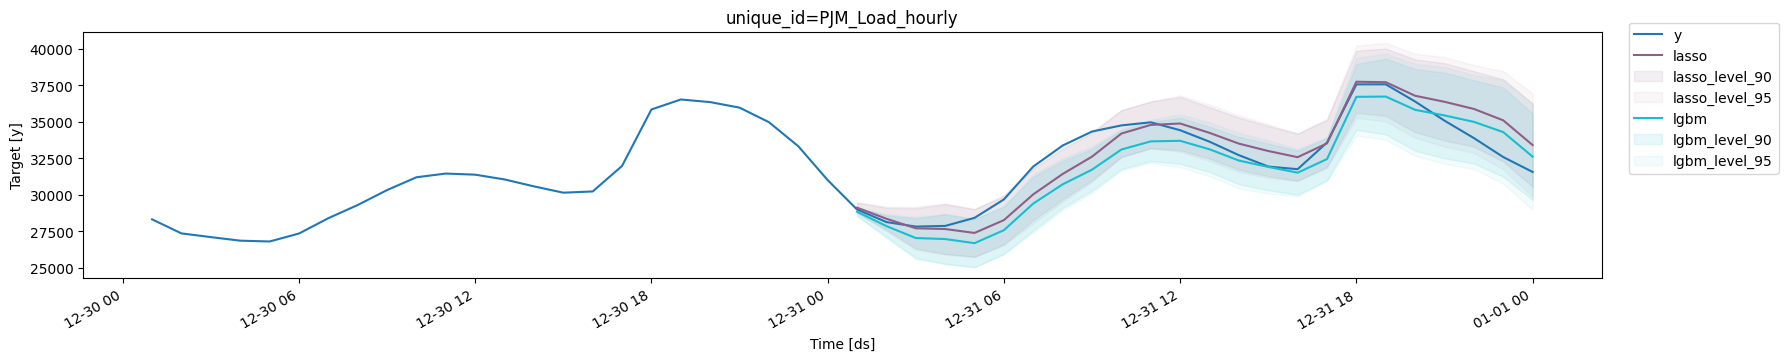

In [93]:
fig = plot_series(
    df_train,
    test_pred,
    models=["lasso", "lgbm"],
    plot_random=False,
    level=[90, 95],
    max_insample_length=24,
)
fig